In [1]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchviz import make_dot

In [2]:
N_skin = 400
N_bandage = 400

In [3]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[-0.4677,  0.0367,  0.43]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([ [-0.4677,  0.0367,  0.45],
                            [-0.4677,  0.0367,  0.5],
                            [-0.4677,  0.0367,  0.55]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [4]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=1, y_length=0.8, z_length=0.24), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.24), x_length=1, y_length=0.8, z_length=0.24), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.add_multi_boundary_constrain(1, 0, 0.1, range(198, 296))
# softbody.init_rigid_constraints(1, 0.3)
# softbody.init_shape_constraints_thinshell([1])
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 306)

detect 2 object


In [5]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [6]:
softbody.V[400 + 306]

tensor([-0.4173, -0.0577,  0.3600])

In [7]:
softbody.C_boundary_list[0].shape

torch.Size([522, 2])

In [8]:
# color = np.zeros(400)
# color[306] = 1

In [9]:
cloth_dist_stiffness = 1e3
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*3

In [10]:
filename = 'tissue2tissue_stiffness_' + str(V_boundary_stiffness_ref) + '.gif'
stiffness_text = 'Boundary stiffness = ' + str(V_boundary_stiffness_ref)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


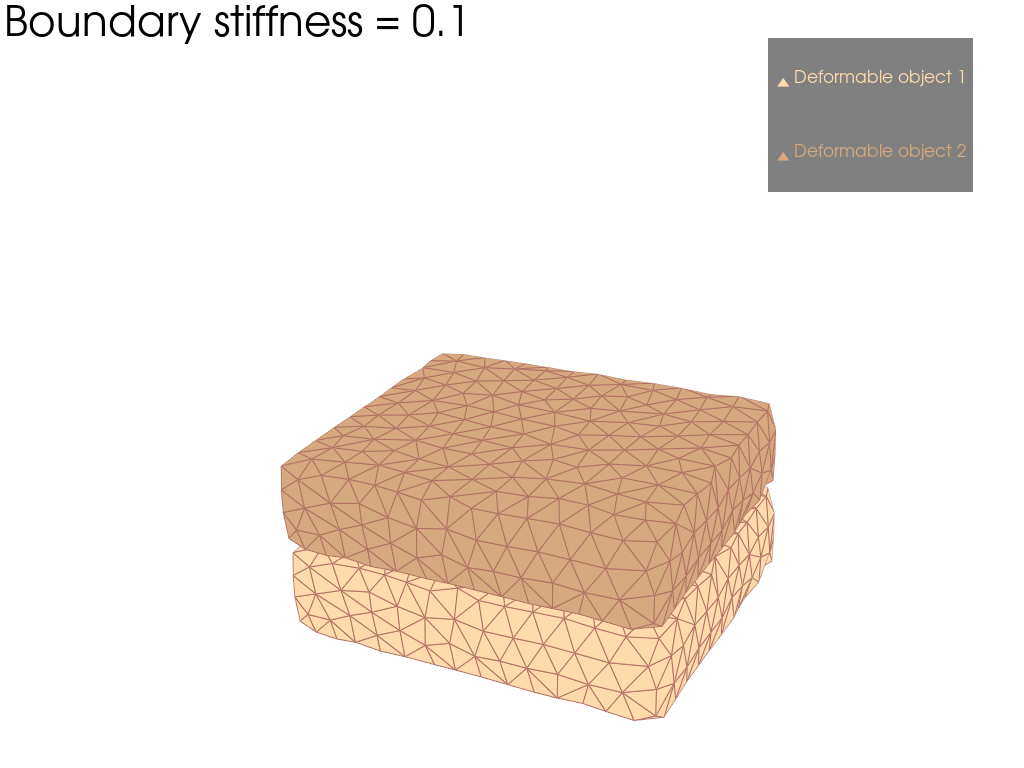

In [11]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_text(stiffness_text)
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = [(-1.5456585149189535, 2.774608471223274, 1.869515302491473),
 (0.04999999999999999, 8.326672684688674e-17, 0.4750000013411045),
 (0.1445792296290427, -0.37671903820836455, 0.9149751978120703)]
pl.show()

In [12]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.4173, -0.0577,  0.3600])

In [13]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[-0.4677,  0.0367,  0.4500],
        [-0.4677,  0.0367,  0.5000],
        [-0.4677,  0.0367,  0.5500]], dtype=torch.float64, requires_grad=True)

In [14]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [15]:
# define loss function
target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target):
    return torch.norm(target - predict)

In [16]:
# # # define loss function
# target = torch.tensor([1, 1, 1])

# def loss_fn(predict, target):
#     return torch.square(torch.norm(target - predict))

In [17]:
softbody.C_dist_list[0].shape

torch.Size([240, 2])

In [18]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([522, 2])

In [19]:
softbody.V

tensor([[-0.4887, -0.3756, -0.1053],
        [-0.4930, -0.2610, -0.1043],
        [-0.4519, -0.3149, -0.1193],
        ...,
        [ 0.0862,  0.0989,  0.3600],
        [ 0.1719,  0.0938,  0.3600],
        [ 0.2500,  0.0773,  0.3600]])

In [20]:
energy_list = []
# pl.open_gif(filename)
for t in range(10):
    # get cubic bezier spline control after step
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.025)
    spline_x = spline[0]
    spline_y = spline[1]
    spline_z = spline[2]
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    # print(spline_trajectory)
    # restore original vertex and velocity
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 1e3
    V_boundary_stiffness_ref = 1e3
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
    # V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*3
    
    for i in range(spline_trajectory.shape[0]):
    # for i in range(1):
        softbody.V[softbody.offset_list[1] + 306] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=False,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        # # energy_list.append(np.sum(energy.detach().cpu().numpy()))
        # # V_boundary_stiffness[energy.squeeze() > 0.5] = 1e-8
        V_boundary_stiffness = ref_V_boundary_stiffness * torch.sigmoid(1e3 * (0.5 - energy)) + 1e-5 * torch.sigmoid(1e3 * (energy - 0.5))
        # print(V_boundary_stiffness)
        # skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
        # bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
        
    # loss = loss_fn(softbody.V[softbody.offset_list[1] + 307], target)
    loss = loss_fn(V_boundary_stiffness, target)
    # loss = torch.norm(V_ref)
    loss.backward()
    print(loss)
    print(spline_control.grad)
        
    optimizer.step()
    optimizer.zero_grad()

# pl.close()

tensor(22847.3191, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
tensor(22847.3191, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
tensor(22847.3191, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


KeyboardInterrupt: 

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


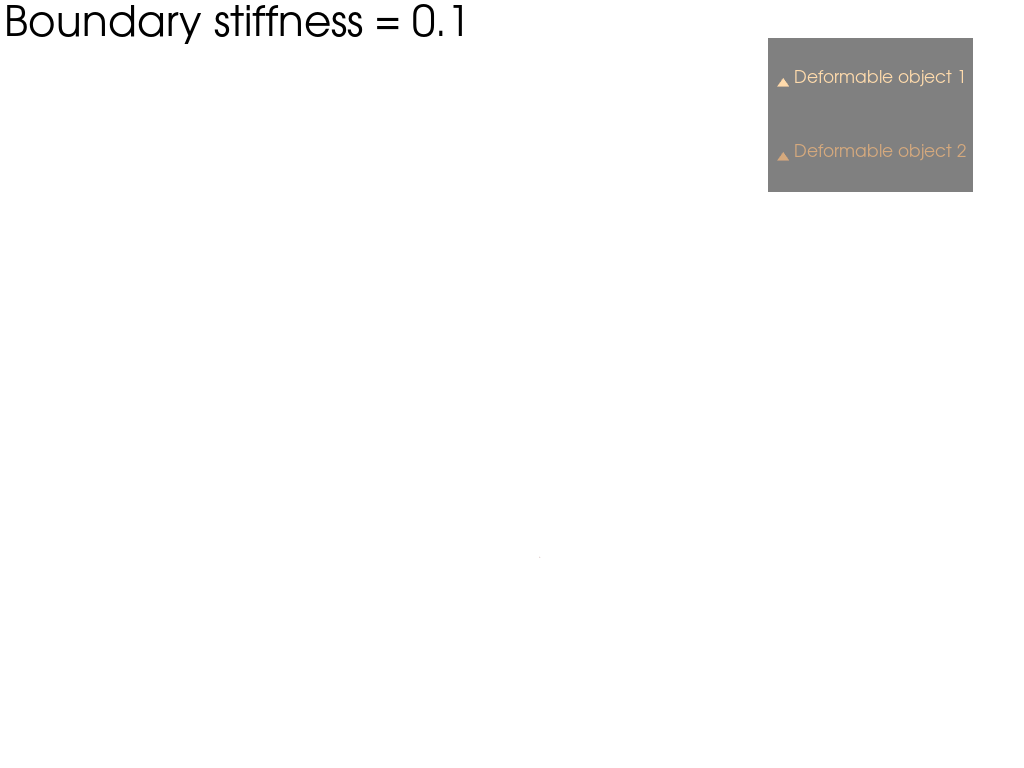

In [ ]:
pl.show()